In [ ]:
pip install tensorflow
pip install requests
pip install pandas
pip install matplotlib
pip install torch
pip install plotly

In [ ]:
pip install plotly

In [1]:
def merge_json_objects(obj1, obj2):
    merged_data = {}

    #add ojb1 into holding dict. if key is found in both, merge them then add
    for key, value in obj1.items():
        if key in obj2:
            merged_data[key] = value+obj2[key]
        else:
            merged_data[key] = value

    #add obj2 into holding dict only if key not in obj1
    for key, value in obj2.items():
        if key not in merged_data:
            merged_data[key] = value
            
    return merged_data

In [2]:
def get_stock_data(url, next_page_token=None):
    # Make a request to the stock price endpoint
    apiKey = 'PKVVMO4VIR8019Z87DV6'
    apiSecret = 'XlEHA9LpAe3lCmbASJY1Ffze3aRhmCdkhvM1SBnf'
    headers = {
        "accept": "application/json",
        "APCA-API-KEY-ID": apiKey,
        "APCA-API-SECRET-KEY": apiSecret
    }
    response = requests.get(url+next_page_token, headers=headers)
    
    # Check if the response is successful
    if response.status_code == 200:
        # Parse the JSON response
        json_data = response.json()
        bars = json_data['bars']
        # Extract stock data from the current page
        current_page_data = {key: bars[key] for key in bars.keys()}
        # Check if there is a next page
        next_page_token = json_data.get('next_page_token')
        if next_page_token is not None:
            # Recursively fetch and merge the next page data
            next_page_data = get_stock_data(url, '&page_token='+next_page_token)
            current_page_data = merge_json_objects(current_page_data, next_page_data)

        return current_page_data

    else:
        # Handle the case where the API request was not successful
        print(f"Error: {response.status_code}")
        return None


In [3]:
# import tensorflow as tf
import pandas as pd
# import matplotlib.pyplot as plt
import requests
from datetime import datetime
import json
import numpy as np

#gets stock data and cleans it
def stock_data(symbols, pathParam, queryParams):
    #base url to build off of
    base_url = "https://data.alpaca.markets/v2/stocks/"

    #add specific api path
    base_url += pathParam

    #add stock symbols to url
    base_url += 'symbols='
    for symbol in symbols:
        base_url += symbol + "%2C";
        base_url[:-3]

    #add params to urls
    for key, value in queryParams.items():
        base_url += "&";
        base_url += key;
        base_url += "=";
        base_url += value;

    #get merged price data
    results = get_stock_data(base_url, '')

    #create list of symbols. FIXME: this could probably use the symbols param. dont know which is faster
    symbols = list(results.keys())
    #create empty dict to hold each symbols data
    tables = {}
    for symbol in symbols:
        #get specific symbol's data
        data = results[symbol]
        
        # Convert timestamp strings to datetime objects
        for point in data:
            #FIXME: make sure every endpoint includes 't' measure
            point["t"] = datetime.strptime(point["t"], "%Y-%m-%dT%H:%M:%SZ")
        
        # Create a Pandas DataFrame
        df = pd.DataFrame(data)
            
            
        # FIXME: This is not needed in prod. Wasted computation. Not agnostic
        df.rename(columns={'c': 'close', 'h':'high', 'l':'low', 'n':'trade_count', 'o':'open', 't':'timestamp', 'v':'bar_volume', 'vw':'price_volume_weighted'}, inplace=True)
    
        # add df to dictionary of dfs
        tables[symbol] = df

    return tables


In [4]:
def create_MACD(data, config):
    firstPerdiod = config['firstPeriod']
    secondPeriod = config['secondPeriod']
    #indicator = {}

    #for symbol, prices in data.items():
    macd1=pd.Series(data['price_volume_weighted'].ewm(span=firstPerdiod, min_periods=1, adjust=False).mean())
    macd2=pd.Series(data['price_volume_weighted'].ewm(span=secondPeriod, min_periods=1, adjust=False).mean())
    macd = pd.Series(macd1 - macd2, name='value')
    indicator = pd.concat([data, macd], axis=1)
    return indicator
    

def create_RSI(data, config):
    period = config['period']
    #indicator = {}

    price_change=pd.Series(data['price_volume_weighted'].diff())

    # Calculate the average gain and average loss over a 14-day period
    gain=pd.Series(price_change.apply(lambda x: x if x > 0 else 0))
    loss=pd.Series(price_change.apply(lambda x: abs(x) if x < 0 else 0))
        
    avg_gain=pd.Series(gain.rolling(window=period, min_periods=1).mean())
    avg_loss=pd.Series(loss.rolling(window=period, min_periods=1).mean())
        
    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = pd.Series(100 - (100 / (1 + rs)), name='value')
    indicator = pd.concat([data, rsi], axis=1)
    return indicator
    
    
def create_MA(data, config):
    period = config['period']
    
    ma=pd.Series(data['price_volume_weighted'].rolling(window=period).mean(), name='value')
    indicator=pd.concat([data, ma], axis=1)
    return indicator
    

def create_PriceDelta(data, config):
    period = config['period']
    
    delta=pd.Series(data['price_volume_weighted'] - data['price_volume_weighted'].shift(period), name='value')
    indicator=pd.concat([data, delta], axis=1)
    return indicator


def create_PriceDeltaPercent(data, config):
    period = config['period']
    point = config['point']
    
    delta=pd.Series(abs(data['price_volume_weighted']-data['price_volume_weighted'].shift(period)))
    final = pd.Series((delta/data['price_volume_weighted'].shift(period))*100, name='value') if point == 'initial' else pd.Series((delta/data['price_volume_weighted'])*100, name='value')
    indicator=pd.concat([data, final], axis=1)
    return indicator

def create_EWMA(data, config):
    period = config['period']

    ewma = pd.Series(data['price_volume_weighted'].ewm(span=period, min_periods=1).mean(), name='value')
    indicator=pd.concat([data, ewma], axis=1)
    return indicator

indicator_functions = {
    'MACD': create_MACD,
    'RSI': create_RSI,
    'MA': create_MA,
    'PriceDelta': create_PriceDelta,
    'PriceDeltaPercent': create_PriceDeltaPercent,
    'EWMA': create_EWMA
}

In [5]:
def create_indicators(stocks, indicator_config):
    indicators_master = {}
    for symbol, data in stocks.items():
        symbol_indicators = {}
        for indicator_name, config in indicator_config.items():
            # Use the indicator_functions dictionary to get the appropriate function
            indicator_function = indicator_functions.get(indicator_name)
            if indicator_function:
                # Call the selected function with the corresponding configuration
                indicator_value = indicator_function(data, config)
                symbol_indicators[indicator_name] = indicator_value
            else:
                print(f"Warning: Unknown indicator '{indicator}'. Skipping.")
        indicators_master[symbol] = symbol_indicators
    return indicators_master

In [6]:
def create_signals(stocks, signal_memory, cutin, cutoff):
    signals_final = {}
    for symbol, bars in stocks.items():
        flipped = bars['price_volume_weighted'][::-1]
        flipped_ewma = flipped.ewm(span=signal_memory, min_periods=0, adjust=False).mean()
        ewma = flipped_ewma[::-1]
        future_change = ewma - bars['price_volume_weighted']
        signal = pd.Series(future_change/bars['price_volume_weighted'], name = 'value')
        full_df = pd.concat([bars[['timestamp']], signal], axis=1)
        signals_final[symbol] = full_df.iloc[cutin:-cutoff].reset_index(drop=True)
    return signals_final

In [ ]:
    # signals_final = {}
    # for symbol, bars in stocks.items():
    #     future_change_abs = pd.Series(bars['price_volume_weighted'].shift(-1) - bars['price_volume_weighted'], name='future_change')
    #     signal = pd.Series(future_change_abs/bars['price_volume_weighted'], name = 'value')
    #     full_df=pd.concat([bars[['timestamp']], signal], axis=1)
    #     signals_final[symbol]=full_df
    # return signals_final
    #x=3

In [7]:
def min_max_scaling(data):
    min_val = np.min(data['value'])
    max_val = np.max(data['value'])
    scaled_data = (data['value'] - min_val) / (max_val - min_val)
    scaled=pd.concat([data['timestamp'], scaled_data], axis=1)
    return scaled

In [8]:
# Clean and format data
def create_features(indicators, cutin, cutoff):
    features = {}
    features_scaled={}
    outputs = {}
    for symbol, indicator_dict in indicators.items():
        feature = {}
        feature_scaled = {}
        output = []
        for indicator_name, indicator_value in indicator_dict.items():
            feature[indicator_name] = indicator_value[['value', 'timestamp']].iloc[cutin:-cutoff].reset_index(drop=True)
            feature_scaled[indicator_name] = min_max_scaling(feature[indicator_name])
        features[symbol]=feature
        features_scaled[symbol]=feature_scaled
    return features, features_scaled

In [9]:
def main(symbols, queryParams, pathParam, indicator_config, signal_memory):
    cutin = 51
    cutoff = 1
    stock_bars = stock_data(symbols, pathParam, queryParams)
    indicators = create_indicators(stock_bars, indicator_config)
    features, features_scaled = create_features(indicators, cutin, cutoff)
    signals = create_signals(stock_bars, signal_memory, cutin, cutoff)
    #cutoff features and signals
    data = {}
    for symbol in symbols:
        data[symbol] = {
            'bars': stock_bars[symbol].iloc[cutin:-cutoff].reset_index(drop=True),
            'indicators': indicators[symbol],
            'features': features[symbol],
            'features_scaled': features_scaled[symbol],
            'signals': signals[symbol]
            
        }
    return data

In [97]:
#init config and get stock price data
symbols = ['AAPL', 'MSFT', 'BRK.B', 'AGL', 'NVDA']
queryParams = {
    'timeframe':'3Min',
    'adjustment': 'all',
    'feed': 'sip',
    'sort': 'asc',
    'start': '2018-09-01T00%3A00%3A00Z',
    'limit': '10000'
             }
pathParam = 'bars?'
#FIXME: change to auto calc the cut off period

#init config and create indicators for each stock
#FIXME: periods here are in # of readings, not days (eg. timeframe=30Min, so period=50 means 3.1 days assuming 8 hour trading day)
indicator_config = {
    # 'MACD': {
    #     'firstPeriod': 1920,
    #     'secondPeriod': 4160,
    # },
    'MACD': {
        'firstPeriod': 12,
        'secondPeriod': 26,
    },
    # 'RSI': {
    #     'period': 2240
    # },
    'RSI': {
        'period': 14
    },
    # 'MA': {
    #     'period': 8000
    # },
    'MA': {
        'period': 50
    },
    'EWMA': {
        'period': 20
    },
    'PriceDelta': {
        'period': 1
    },
    'PriceDeltaPercent': {
        'period': 1,
        'point': 'initial'
    }
}

#indicators, signals = main(symbols, queryParams, pathParam, indicator_config)
data = main(symbols, queryParams, pathParam, indicator_config, signal_memory=10)

In [57]:
# Build net
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go
import seaborn as sns

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        #x = self.softmax(x)
        return x
        
def create_model(data, lr, epoch_length, shuffle_bool):
    training_loss={}
    input_size = len(data['features_scaled'])
    train_size = int(0.8 * len(data['features_scaled'][list(data['features_scaled'].keys())[0]]))

    feature_scaled = list(zip(*[feature['value'] for feature in data['features_scaled'].values()]))

    output = np.array(data['signals']['value'])
    feature_train = feature_scaled[:train_size]
    output_train = output[:train_size]
    feature_test = feature_scaled[train_size:]
    output_test = output[train_size:]
    
    X_train_tensor=torch.FloatTensor(feature_train)
    y_train_tensor = torch.FloatTensor(output_train)
    
    X_test_tensor = torch.FloatTensor(feature_test)
    y_test_tensor = torch.FloatTensor(output_test)
    
    # Set hyperparameters
    hidden_size = 64
    output_size = 1
    learning_rate = lr
    epochs = epoch_length
    
    # Create an instance of the model
    model = NeuralNetwork(input_size, hidden_size, output_size)
        
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
    # Prepare DataLoader for training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=shuffle_bool)
    
    # Training loop
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            # Zero the gradients
            optimizer.zero_grad()
        
            # Forward pass
            model_output = model(inputs)
                
            # Compute the loss
            labels = labels.view_as(model_output)
            loss = criterion(model_output, labels)
    
            # Backward pass
            loss.backward()
        
            # Update weights
            optimizer.step()
        
        # Print the training loss for each epoch
        training_loss[epoch]=loss.item()

    # #graph loss
    # plt.plot(training_loss.keys(), training_loss.values(), marker='o', linestyle='-', color='b')
    # plt.title(f'Training Loss Over Time with lr:{lr}, epoch:{epoch_length}, shuffle:{shuffle_bool}')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.grid(True)
    # plt.show()

    # with torch.no_grad():
    #     model.eval()
    #     test_outputs = model(X_test_tensor)
    #     test_outputs_np = test_outputs.numpy().squeeze()

    #     threshold = 0.0
        
    #     # Convert probabilities to binary predictions
    #     predicted_labels = [1 if num > 0 else -1 for num in test_outputs.numpy()]

    #     # Convert tensors to numpy arrays
    #     y_true = y_test_tensor.numpy().flatten()
    #     true_labels = [1 if num > 0 else -1 for num in y_true]
                    
    #     # Create the confusion matrix
    #     cm = confusion_matrix(true_labels, predicted_labels)
            
    #     # Plot the confusion matrix using seaborn
    #     # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    #     # plt.xlabel("Predicted Labels")
    #     # plt.ylabel("True Labels")
    #     # plt.title("Confusion Matrix")
    #     # plt.show()
        
    #     #Create price graph scatter graph
    #     test_outputs = model(torch.FloatTensor(feature_scaled))
    #     test_outputs_np = test_outputs.numpy().squeeze()
    #     x = np.arange(len(test_outputs_np))
    #     #colors = ['red' if val < 0 else 'green' for val in test_outputs_np]
    #     plt.figure(figsize=(15, 6))
    #     plt.scatter(data['signals']['timestamp'], data['bars']['price_volume_weighted'], c='b', marker='o', s=5, label='Markers', edgecolors='none') 

    #     #create model output graph
    #     smooth_window = 100
    #     kernel = np.ones(smooth_window) / smooth_window
    #     smoothed_array = np.convolve(test_outputs_np, kernel, mode='same')
    #     scale_limit = min(data['bars']['price_volume_weighted'])
    #     scaled_array = np.interp(smoothed_array, (min(smoothed_array), max(smoothed_array)), (-10, 10))
    #     colors = ['red' if val < 0 else 'green' for val in smoothed_array]
    #     plt.scatter(data['signals']['timestamp'], scaled_array, c=colors, marker='o', s=5, label='Markers', edgecolors='none') 

    #     plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=1)
    #     plt.show()

    return model, training_loss

In [12]:
models = {}

In [35]:
class Model:
    def __init__ (self, model, training_loss, symbol, lr, epoch_length, shuffle_bool):
        self.model = model
        self.training_loss = training_loss
        self.symbol = symbol
        self.lr = lr
        self.epoch_length = epoch_length
        self.shuffle_bool = shuffle_bool

    def graph_loss(self):
        plt.plot(self.training_loss.keys(), self.training_loss.values(), marker='o', linestyle='-', color='b')
        plt.title(f'Training Loss Over Time with lr:{self.lr}, epoch:{self.epoch_length}, shuffle:{self.shuffle_bool}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    def graph_output(self, data, smooth_window=1, scale_center=0, scale_size=10, start=False, granularity=False):
        feature_scaled = list(zip(*[feature['value'] for feature in data['features_scaled'].values()]))
        with torch.no_grad():
            self.model.eval()
    
            #Create price graph scatter graph
            test_outputs = model(torch.FloatTensor(feature_scaled))
            test_outputs_np = test_outputs.numpy().squeeze()
            x = np.arange(len(test_outputs_np))
            if not start:
                start = 0
            if not granularity:
                granularity = len(x)-start

            start = int(len(x)*start)
            granularity = int(len(x)*granularity)

            if start+granularity >= len(x):
                granularity = len(x)-start
            
            plt.figure(figsize=(15, 6))
            plt.scatter(data['signals']['timestamp'].iloc[start:start+granularity], data['bars']['price_volume_weighted'].iloc[start:start+granularity], c='b', marker='o', s=5, label='Markers', edgecolors='none') 
    
            #create model output graph
            kernel = np.ones(smooth_window) / smooth_window
            smoothed_array = np.convolve(test_outputs_np, kernel, mode='same')
            scale_limit = min(data['bars']['price_volume_weighted'])
            scaled_array = np.interp(smoothed_array, (min(smoothed_array), max(smoothed_array)), (scale_center-scale_size, scale_center+scale_size))
            colors = ['red' if val < 0 else 'green' for val in smoothed_array[start:start+granularity]]
            plt.scatter(data['signals']['timestamp'].iloc[start:start+granularity], scaled_array[start:start+granularity], c=colors, marker='o', s=5, label='Markers', edgecolors='none') 
            plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=1)
            plt.show()

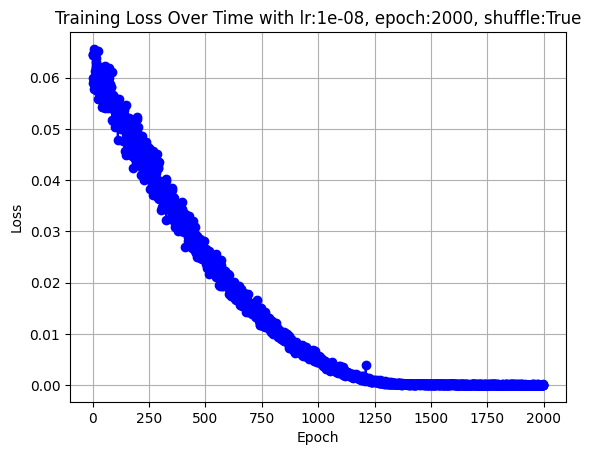

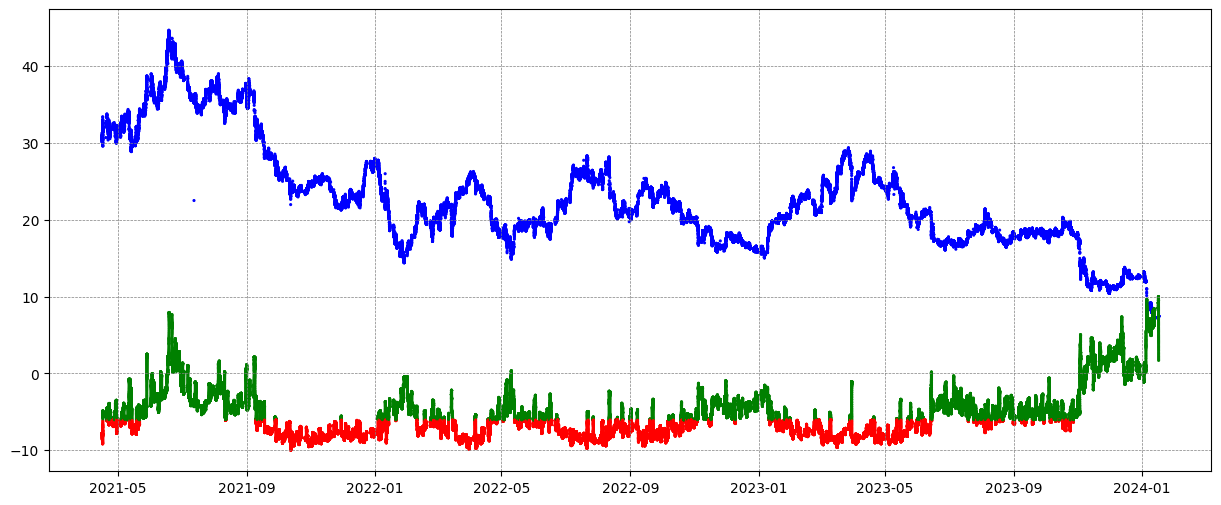

In [775]:
model, training_loss = create_model(data=data['AGL'], lr=.00000001, epoch_length=2000, shuffle_bool=True)

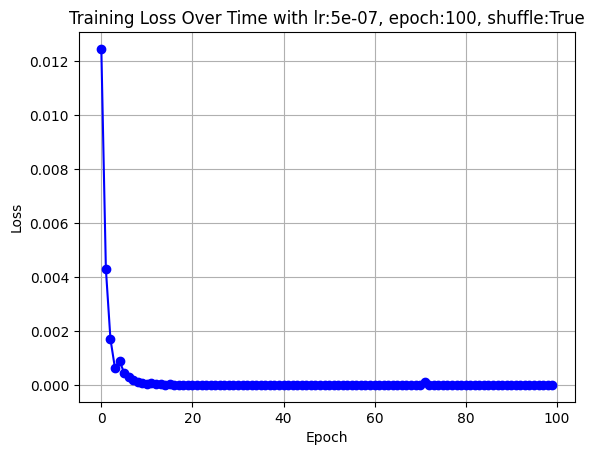

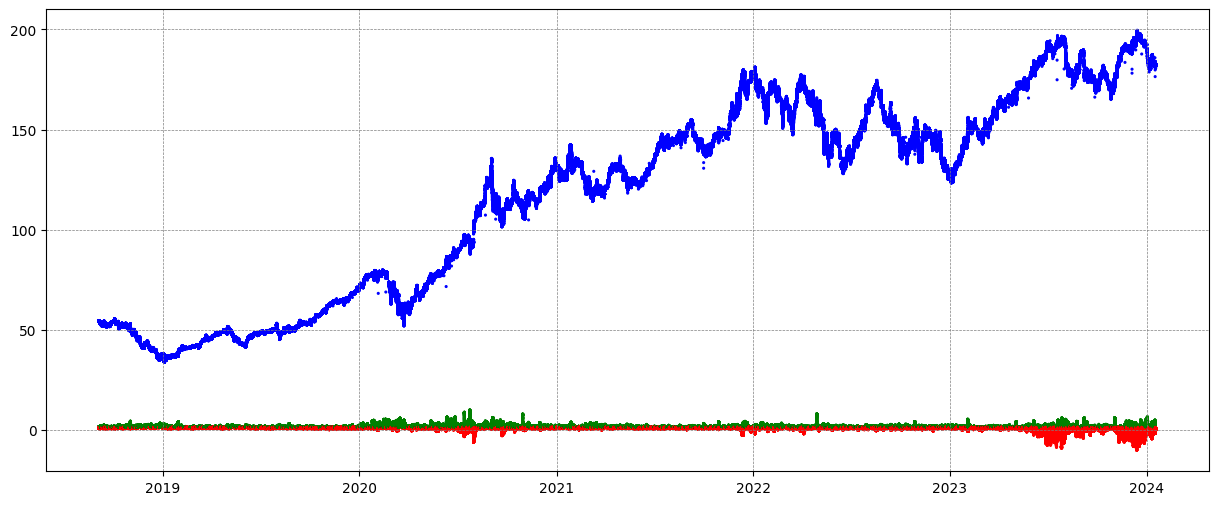

In [40]:
model, training_loss = create_model(data=data['AAPL'], lr=.0000005, epoch_length=100, shuffle_bool=True)

In [824]:
model, training_loss = create_model(data=data['AGL'], lr=.0000005, epoch_length=50, shuffle_bool=True)

In [ ]:
with torch.no_grad():
    model.eval()
    feature_scaled = list(zip(*[feature['value'] for feature in data['AGL']['features_scaled'].values()]))
    model_outputs = model(torch.FloatTensor(feature_scaled))
    model_outputs_np = model_outputs.numpy().squeeze()
    scaled_array = np.interp(model_outputs_np, (min(model_outputs_np), max(model_outputs_np)), (1, 100))
    print(len(model_outputs_np))
    plt.figure(figsize=(15, 6))
    plt.plot(scaled_array)
    plt.show()
    plt.figure(figsize=(15, 6))
    plt.plot(model_outputs_np)
    plt.show()

    kernel = np.ones(1000) / 1000
    smoothed_array = np.convolve(model_outputs_np, kernel, mode='valid')
    plt.figure(figsize=(15, 6))
    plt.plot(smoothed_array)
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=1)
    plt.show()

    print(len(smoothed_array))
    print(len(model_outputs_np))

In [ ]:
with torch.no_grad():
        zoom = 120
        symbol = 'AGL'
        model.eval()
        feature_scaled = list(zip(*[feature['value'] for feature in data[symbol]['features_scaled'].values()]))
        model_outputs = model(torch.FloatTensor(feature_scaled))
        model_outputs_np = model_outputs.numpy().squeeze()
        
        #Create price graph scatter graph
        plt.figure(figsize=(15, 6))
        plt.scatter(data[symbol]['signals']['timestamp'].iloc[-zoom:], data[symbol]['bars']['price_volume_weighted'].iloc[-zoom:], c='b', marker='o', s=5, label='Markers', edgecolors='none') 

        #create model output graph
        smooth_window = 10
        kernel = np.ones(smooth_window) / smooth_window
        smoothed_array = np.convolve(model_outputs_np, kernel, mode='same')
        scale_limit = min(data[symbol]['bars']['price_volume_weighted'])
        scaled_array = np.interp(smoothed_array, (min(smoothed_array), max(smoothed_array)), (6.9, 7.1))
        colors = ['red' if val < 0 else 'green' for val in smoothed_array[-zoom:]]
        plt.scatter(data[symbol]['signals']['timestamp'].iloc[-zoom:], scaled_array[-zoom:], c=colors, marker='o', s=5, label='Markers', edgecolors='none') 

        plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=1)
        plt.show()

In [ ]:
##### from collections import deque
def test_model(model, data, bank):
    pricing_data = data['bars']['price_volume_weighted'].values
    bank = bank
    with torch.no_grad():
            model.eval()
            feature_scaled = list(zip(*[feature['value'] for feature in data['features_scaled'].values()]))
            model_outputs = model(torch.FloatTensor(feature_scaled))
            model_outputs_np = model_outputs.numpy().squeeze()
            data['signals']['output'] = model_outputs_np
    
            for choice in data['signals']['output']:
            #    if choice > 0:
                    #Buy
            #    if choice < 0:
                    #short
                print(choice)

In [ ]:
#graph signals
zoom = 400000
colors = ['red' if val <= 0 else 'green' for val in data['AAPL']['signals']['value'].iloc[-zoom:]]
plt.figure(figsize=(15, 6))
plt.scatter(data['AAPL']['signals']['timestamp'].iloc[-zoom:], data['AAPL']['bars']['price_volume_weighted'].iloc[-zoom:], c=colors, marker='o', s=5, label='Markers', edgecolors='none') 
plt.title("Your Plot Title")
plt.xlabel("X-axis Label")
plt.ylabel("Y-axis Label")
plt.show()

In [ ]:
#graph feature
data['AAPL']['features']['RSI'].plot(y='value', x='timestamp', kind='scatter', color='b', figsize=(20, 6))
#data['AAPL']['bars'].plot(x='timestamp', y='price_volume_weighted', kind='line', linestyle='-', color='b', figsize=(20, 6))
plt.title(f'Time vs feature')
plt.xlabel('Time')
plt.ylabel('feature')
plt.grid(True)

In [41]:
models['AAPL_Short_v0.1'] = Model(model, training_loss, 'AAPL', .0000005, 100, True)

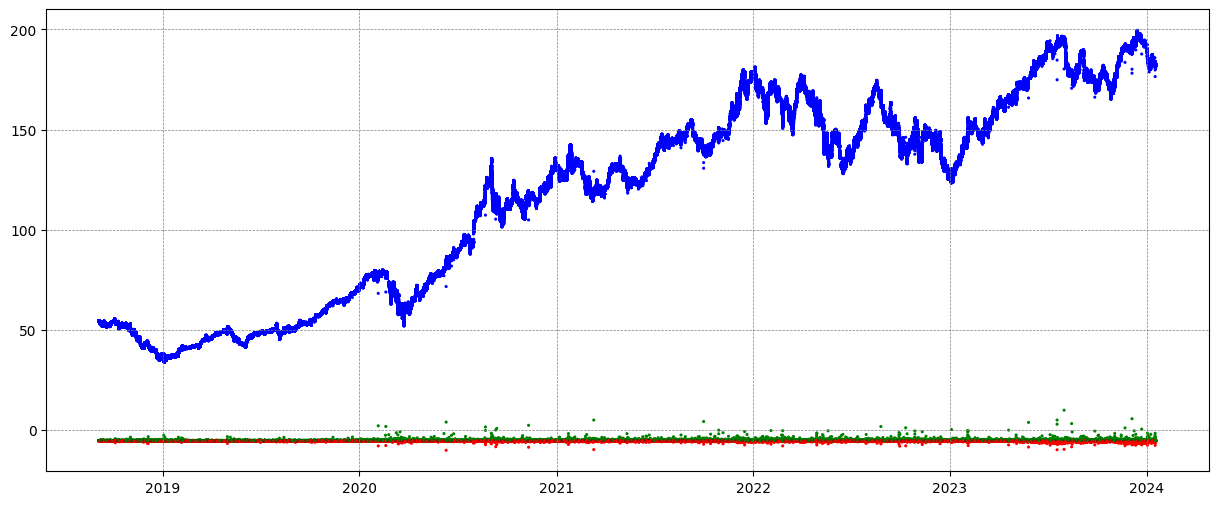

In [53]:
models['AAPL_Short_v0.1'].graph_output(data['AAPL'])

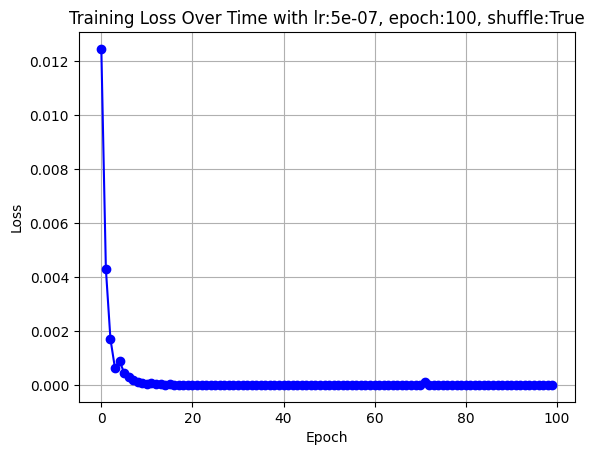

In [42]:
models['AAPL_Short_v0.1'].graph_loss()

In [54]:
def create_save(symbol, data, lr, epoch_length, shuffle_bool):
    model, training_loss = create_model(data, lr, epoch_length, shuffle_bool)
    models[symbol + ":" + str(lr) + ":" + str(epoch_length) + ":" + str(shuffle_bool)] = Model(model, training_loss, symbol, lr, epoch_length, shuffle_bool)




In [62]:
create_save('AAPL', data['AAPL'], .001, 30, True)

In [99]:
#training loop
for symbol, symbol_data in data.items():
    for i in range(10, 1000, 20):
        for j in range (2, 10):
            lr =  .0001/2**j
            epoch_length = i
            print("creating model: " + symbol + ":" + str(lr) + ":" + str(epoch_length) + ":" + "True")
            create_save(symbol, data, lr, epoch_length, True)
            print("created.")

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



{'bars':          close    high       low  trade_count      open           timestamp  \
0        54.40   54.40   54.4000           22   54.4000 2018-09-04 11:54:00   
1        54.44   54.44   54.4000           33   54.4000 2018-09-04 11:57:00   
2        54.42   54.52   54.3300          169   54.4800 2018-09-04 12:00:00   
3        54.40   54.42   54.3900           78   54.4200 2018-09-04 12:03:00   
4        54.42   54.43   54.4200           16   54.4200 2018-09-04 12:06:00   
...        ...     ...       ...          ...       ...                 ...   
386918  182.40  182.40  182.3100           50  182.3200 2024-01-18 00:39:00   
386919  182.40  182.45  182.4000           25  182.4000 2024-01-18 00:42:00   
386920  182.45  182.45  182.4000           21  182.4000 2024-01-18 00:45:00   
386921  182.47  182.47  182.4699            8  182.4699 2024-01-18 00:51:00   
386922  182.48  182.50  182.4700           25  182.4700 2024-01-18 00:54:00   

        bar_volume  price_volume_weighted 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 